# Kendall's τ of spatial covariance

## Packages

## Variables to be defined

In [7]:
from tkinter import font
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.colors as colors


from figure_params import *


In [18]:
amazon_basin = xr.open_dataarray('data/amazon_basin_mask.nc')

dataMap = xr.Dataset({
    "AMSR-E band C\n2002-2011": xr.open_dataarray("data/csd_trends_AMSRE_bandC.nc"),
    "AMSR-E band X\n2002-2011": xr.open_dataarray("data/csd_trends_AMSRE_bandX.nc"),
    "AMSR2 band C1\n2012-2020": xr.open_dataarray("data/csd_trends_AMSR2_bandC1.nc"),
    "AMSR2 band C2\n2012-2020": xr.open_dataarray("data/csd_trends_AMSR2_bandC2.nc")
}).to_array("VI")
dataMap = (dataMap>0).sum("indicator").where(dataMap.sel(indicator="SpatialCorrelation").notnull())


dataTS = xr.Dataset({
    "AMSR-E band C\n2002-2011": xr.open_dataarray("data/csd_indicator_AMSRE_bandC.nc"),
    "AMSR-E band X\n2002-2011": xr.open_dataarray("data/csd_indicator_AMSRE_bandX.nc"),
    "AMSR2 band C1\n2012-2020": xr.open_dataarray("data/csd_indicator_AMSR2_bandC1.nc"),
    "AMSR2 band C2\n2012-2020": xr.open_dataarray("data/csd_indicator_AMSR2_bandC2.nc")
}).to_array("VI")
dataTS = dataTS.mean(("lon", "lat"))

In [102]:
ncol = 4
cindicators = [c_orange, "m", c_dark_violet]

# FOR MAPS
def plot_map(data, axis):
    p = data.plot(x="lon", transform=transform_data, ax=axis, cmap=cmap_sum, vmin=0, vmax=3, add_colorbar=False)
    amazon_basin.where(amazon_basin).plot(ax=axis, transform=transform_data, cmap=cmap_nan, zorder=0, add_colorbar=False)
    amazon_basin.plot.contour(ax=axis, transform=transform_data, cmap="k", zorder=0)

    axis.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', zorder=0, facecolor=color_land, alpha=.4))
    axis.add_feature(cf.BORDERS)
    
    # # make map prettier
    axis.set_extent(map_extent)
    axis.axis("off")
    return p


def make_colorbar(fig, p, axis, data):
    ticks = np.linspace(1./3,3-1./3,4)
    cbar = fig.colorbar(
        p, 
        ax=axis, 
        shrink=0.85, 
        fraction = .06,
        label = ("Number of positive trends"),
        ticks=ticks,
        location="bottom", 
    )
    nCtotal = data.notnull().sum().values/100.
    cbar.ax.set_xticklabels([int(i) for i in np.linspace(0,3,4)])
    for i, xpos in enumerate(ticks): cbar.ax.text(xpos, 1.41, "%3.1f%%"%((data==int(i)).sum().values/nCtotal), ha="center", va="center", fontsize=12, bbox=bbox_props)


# FOR TIMESERIES
    
def configure_time_axes_new(data, axis, show_xaxis):
    axis.spines["bottom"].set_visible(show_xaxis)
    axis.set_xlabel("")
    if show_xaxis:
        xticks = [d for d in data.time.values if str(d)[5:10]=="01-01"]
        xtickl = ["Jan "+str(d)[:4] for d in xticks]
        axis.set_xticks(xticks)
        axis.set_xticklabels(xtickl, rotation = -35, fontdict={"horizontalalignment": "left"})
        axis.tick_params(axis="x", direction="in", length=10, width=1)
    else:
        axis.set_xticks([])

def configure_yaxis(axis, sideLeft, pad, color):
    if axis.get_ylim()[1] < 0.01:
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((0,0))
        axis.yaxis.set_major_formatter(formatter)
    side = ["left", "right"][sideLeft]
    pad =  pad+1 if sideLeft else -pad
    axis.spines[side].set_position(("axes", pad))
    axis.yaxis.set_label_position(side)
    axis.yaxis.set_ticks_position(side)
    axis.spines[side].set_color(color)
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)#, fontsize=fontsize_ticks)

    other_side = "right" if side == "left" else "left"
    axis.spines['top'].set_visible(False)
    axis.spines[other_side].set_visible(False)
    axis.spines['bottom'].set_visible(False)


/home/lanabl/.conda/envs/env23/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


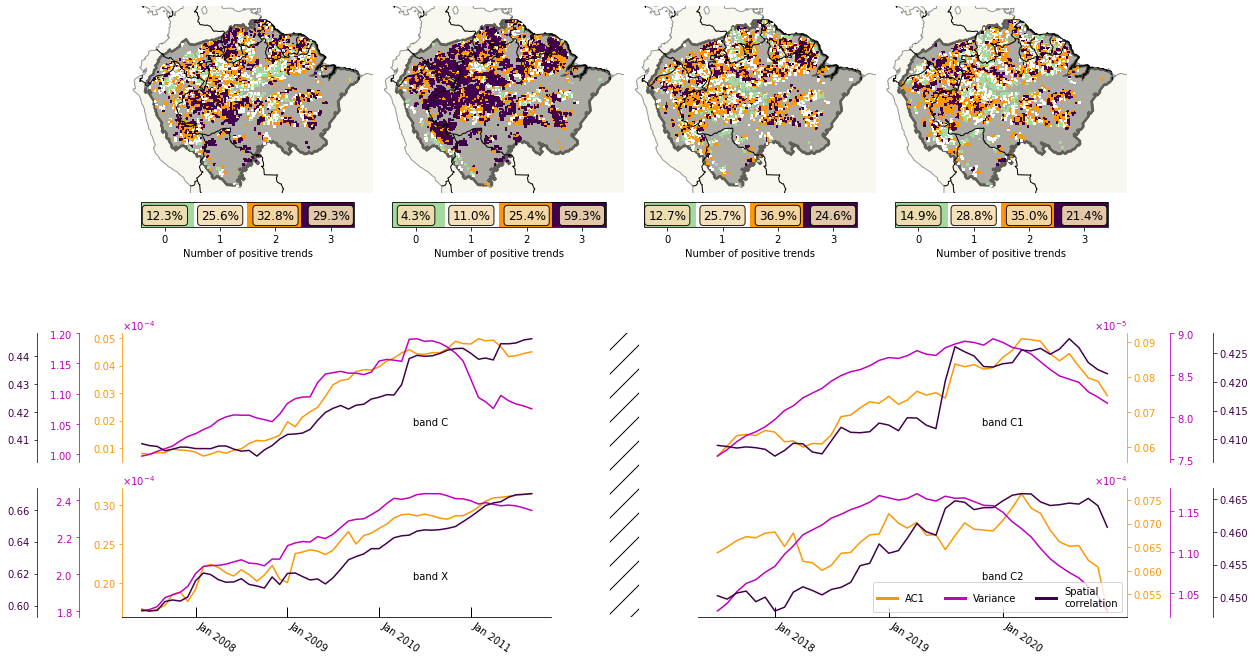

In [108]:
fig = plt.figure(constrained_layout=True, figsize=(18,15))
fig.set_facecolor("w")
gs0 = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[9,.2,6])


##################
# Maps
gsM  = gridspec.GridSpecFromSubplotSpec(1,ncol, subplot_spec=gs0[0], wspace=.001)
for g, vi in zip(gsM, dataMap.VI.values):
    ax = fig.add_subplot(g, projection=map_proj)
    p = plot_map(dataMap.sel(VI=vi), axis=ax)
    make_colorbar(fig, p, ax, dataMap.sel(VI=vi))


# ##################
# # Time series
gs  = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[-1], width_ratios  = [15,1,15])


ax_hatched_center = fig.add_subplot(gs[:,1])
ax_hatched_center.contourf([[0,1],[0,1]],  hatches=['/'], alpha=0)
ax_hatched_center.set_axis_off()

for j, vi in enumerate(dataTS.VI.values):

    ax1 = fig.add_subplot(gs[j%2, (j//2)*2])
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    for i, indicator, c, ax in zip(range(3), dataTS.indicator.values, cindicators, [ax1, ax2, ax3]):
        dataTS.sel(VI=vi, indicator=indicator, drop=True).plot(x="time", label=indicator.replace("lC", "l c"), ax=ax, c=c)
        configure_yaxis(ax, j//2, .0001+i*.1, c)
    configure_time_axes_new(dataTS.sel(VI=vi).dropna("time", "all"), ax1, show_xaxis=j%2)
    ax3.text(.76,.35, "band "+vi.split(" ")[2].split("\n")[0], {'ha': 'right', 'va': 'top'}, transform=ax3.transAxes)

    if j==3:
        legend_elements = [Line2D([0],[0], color=c, lw=3, label=indic.replace("lC", "l\nc")) for indic, c in zip(dataTS.indicator.values, cindicators)]
        ax.legend(handles=legend_elements, loc='lower right', ncol=len(dataTS.indicator.values))
